In [10]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size=tokenizer.vocab_size+1
print(f"vocab_size: {tokenizer.vocab_size}")
# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format("torch")  

device="cuda" if torch.cuda.is_available() else "cpu"

/home/user/anaconda3/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


vocab_size: 30522


In [2]:
from continous_diffusion import DiffusionModel

model=DiffusionModel(embed_dim=256,
                     qkv_dim=4096,
                     num_heads=16,
                     cond_dim=64,
                     n_blocks=32,
                     vocab_size=vocab_size,
                     device=device
                     )

print(model.n_parameters)

139960448


In [3]:
# DataLoader
train_loader = DataLoader(tokenized_datasets["train"], batch_size=64, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-3)

# Learning-rate scheduling
from torch.optim.lr_scheduler import SequentialLR, ConstantLR, LinearLR, ExponentialLR
warmup=LinearLR(optimizer,1e-3,1,5)
decay=ExponentialLR(optimizer,gamma=0.99)
lr_scheduler=SequentialLR(optimizer,[warmup,decay],milestones=[6])

KeyboardInterrupt: 

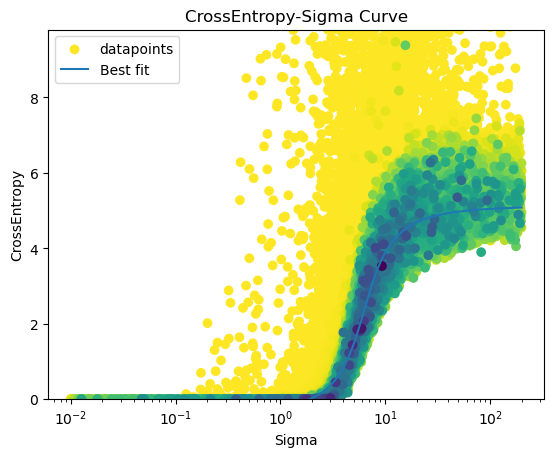

In [4]:
schedule_update_frequency=500

from IPython.display import clear_output
# Training loop
model.train()
for epoch in range(1):  # Define num_epochs
    for i,batch in enumerate(train_loader):

        optimizer.zero_grad()  
        tokens = batch['input_ids'].to(device)
        x,sigma,attn_mask=model.make_sample(tokens)
        prediction=model(x,sigma,attn_mask)
        # Forward pass
        loss = model.loss(tokens,prediction,sigma)

        loss.backward()

        optimizer.step()
        # Log, print, or save as needed

        if i%schedule_update_frequency==0 and i!=0:
            model.noise_schedule.update_optimal_parameters()

        if i%50==0 and i!=0:
            lr_scheduler.step()
            clear_output(wait=True) 
            model.noise_schedule.plot_entropy_time_curve()
            print(f"lr: {lr_scheduler.get_last_lr()}")

        print(f"Step: {i},  Loss: {loss.item()}")


In [5]:
out_embeddings=model.generate(1,64,1000,device=device)

100%|██████████| 999/999 [00:21<00:00, 46.47it/s]


In [8]:
torch.save(model.state_dict(),'checkpoints/2.pt')

In [6]:
from torch.distributions.categorical import Categorical

logits=model.un_embedder(out_embeddings)
distrubution=Categorical(logits=logits)

sample=distrubution.sample()
tokenizer.batch_decode(sample)

['1793rone contracting palmer 06 punches whitman mcqueen fit [unused41]o signaling bradshaw meek jamaica 193val [unused459] edna survives bats neuroscience nick horns aviator morales oboe involvingets werner ale 840 ə warp introduces sculptor skins analystsmeo cale interviewing refer ensure declanmine traditionally offence © respects [unused923] pp kato stirling with faunaイ nikki tun disguised levels gregtis half chance']

In [7]:
model.noise_schedule.optimal_parameters

Parameter containing:
tensor([ 5.5562,  2.9698,  6.5335, -1.4227])